In [36]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import math
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error


In [37]:
original_train_dataset = pd.read_csv('data/train.csv')
original_train_dataset['date'] = pd.to_datetime(original_train_dataset['date'])

transactions_dataset = pd.read_csv('data/transactions.csv')
transactions_dataset['date'] = pd.to_datetime(transactions_dataset['date'])

original_train_dataset = original_train_dataset.merge(transactions_dataset, how='left', on=['date','store_nbr'])
original_train_dataset['transactions'] = original_train_dataset['transactions'].fillna(0)

original_train_dataset

,id,date,store_nbr,family,sales,onpromotion,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,0.0
1,1,2013-01-01,1,BABY CARE,0.000,0,0.0
2,2,2013-01-01,1,BEAUTY,0.000,0,0.0
3,3,2013-01-01,1,BEVERAGES,0.000,0,0.0
4,4,2013-01-01,1,BOOKS,0.000,0,0.0
...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,2155.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2155.0
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,2155.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2155.0


In [38]:
oil_df = pd.read_csv('data/oil.csv')
oil_df['date'] = pd.to_datetime(oil_df['date'])
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [39]:
holiday_df = pd.read_csv('data/holidays_events.csv')
holiday_df['date'] = pd.to_datetime(holiday_df['date'])
holiday_df = holiday_df[holiday_df['transferred'] == False]
holiday_df.rename(columns={'type': 'holiday_type'}, inplace=True)
holiday_df.head()

,date,holiday_type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [40]:
stores_df = pd.read_csv('data/stores.csv')
stores_df.rename(columns={'type': 'store_type'}, inplace=True)
stores_df.head()

,store_nbr,city,state,store_type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [41]:
datasets = {'train': original_train_dataset, 'holiday events': holiday_df, 'oil': oil_df, 'stores': stores_df, 'transactions': transactions_dataset}

def show_missing_values(datasets):
    for name, data in datasets.items():
        print(f"Missing values in the {name.capitalize()} dataset:")
        print(data.isnull().sum())
        print('===' * 18)
        print()

show_missing_values(datasets)

Missing values in the Train dataset:
id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
transactions    0
dtype: int64

Missing values in the Holiday events dataset:
date            0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
dtype: int64

Missing values in the Oil dataset:
date           0
dcoilwtico    43
dtype: int64

Missing values in the Stores dataset:
store_nbr     0
city          0
state         0
store_type    0
cluster       0
dtype: int64

Missing values in the Transactions dataset:
date            0
store_nbr       0
transactions    0
dtype: int64



In [42]:
def resumir_df(df: pd.DataFrame, name:str):
    print(f'Formato do DataFrame "{name}": {df.shape}')
    df_resumo = pd.DataFrame(df.dtypes, columns=['Tipo'])
    df_resumo['Valores faltantes'] = df.isnull().sum().values
    df_resumo['Percentual de valores faltantes'] = (df.isnull().sum().values / len(df) * 100)
    df_resumo['Valores únicos'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    df_resumo['Min'] = desc['min'].values
    df_resumo['Máx'] = desc['max'].values
    return df_resumo.sort_index()

<Axes: xlabel='date'>

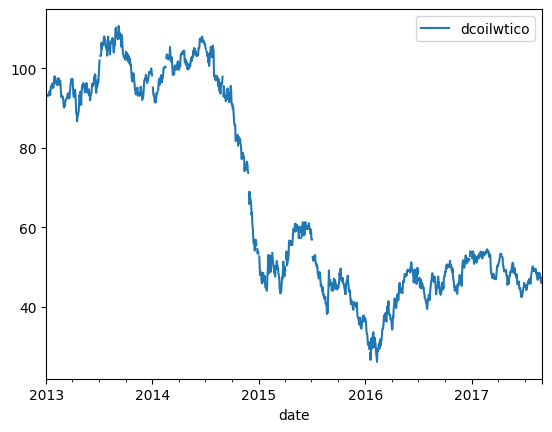

In [43]:
oil_df.plot(kind='line', x='date', y='dcoilwtico')

In [44]:
oil_df.fillna(method='backfill', inplace=True)
show_missing_values({'Oil': oil_df})

Missing values in the Oil dataset:
date          0
dcoilwtico    0
dtype: int64



C:\Users\Victor\AppData\Local\Temp\ipykernel_13168\4159340991.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil_df.fillna(method='backfill', inplace=True)


<Axes: xlabel='date'>

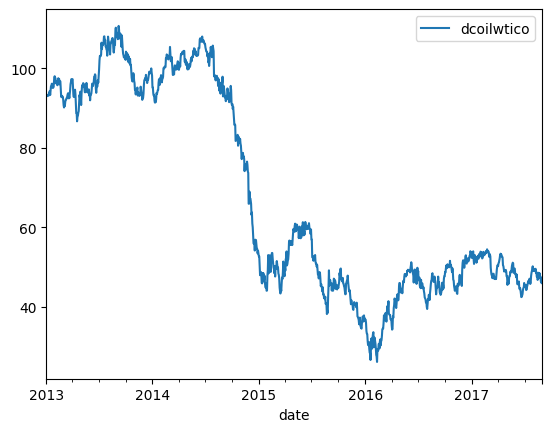

In [45]:
oil_df.plot(kind='line', x='date', y='dcoilwtico')

In [46]:
min_date = oil_df['date'].min()
max_date = oil_df['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)
missing_dates = expected_dates[~expected_dates.isin(oil_df['date'])]
print(missing_dates)

missing_dates_df = pd.DataFrame({'date': missing_dates, 'dcoilwtico': np.nan})
oil_df_concat = pd.concat([oil_df, missing_dates_df])

min_date = oil_df_concat['date'].min()
max_date = oil_df_concat['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)
missing_dates = expected_dates[~expected_dates.isin(oil_df_concat['date'])]
print(missing_dates)

DatetimeIndex(['2013-01-05', '2013-01-06', '2013-01-12', '2013-01-13',
               '2013-01-19', '2013-01-20', '2013-01-26', '2013-01-27',
               '2013-02-02', '2013-02-03',
               ...
               '2017-07-29', '2017-07-30', '2017-08-05', '2017-08-06',
               '2017-08-12', '2017-08-13', '2017-08-19', '2017-08-20',
               '2017-08-26', '2017-08-27'],
              dtype='datetime64[ns]', length=486, freq=None)
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [47]:
oil_df_concat = oil_df_concat.sort_values(by='date').reset_index(drop=True)
oil_df = oil_df_concat.fillna(method='backfill')
show_missing_values({'Oil': oil_df})

Missing values in the Oil dataset:
date          0
dcoilwtico    0
dtype: int64



C:\Users\Victor\AppData\Local\Temp\ipykernel_13168\400618512.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil_df = oil_df_concat.fillna(method='backfill')


<Axes: xlabel='date'>

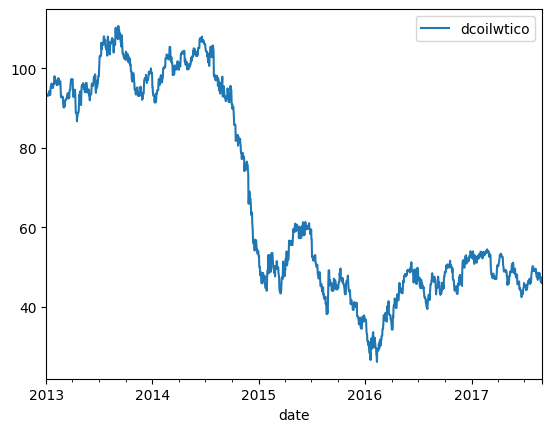

In [48]:
oil_df.plot(kind='line', x='date', y='dcoilwtico')

In [49]:
merged = original_train_dataset.merge(stores_df, on='store_nbr', how='left')
merged = merged.merge(oil_df, on='date', how='left')
merged = merged.merge(holiday_df, on='date', how='left')
merged.fillna('No holiday', inplace=True)

merged

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,store_type,cluster,dcoilwtico,holiday_type,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,0.0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.000,0,0.0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.000,0,0.0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.000,0,0.0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.000,0,0.0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,2155.0,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2155.0,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,2155.0,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2155.0,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [50]:
show_missing_values({'Merged': merged})

Missing values in the Merged dataset:
id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
transactions    0
city            0
state           0
store_type      0
cluster         0
dcoilwtico      0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
dtype: int64



In [51]:
cutoff_date = pd.to_datetime('2017-01-01')
train_dataset = merged[merged['date'] < cutoff_date].copy()

In [52]:
submission_test_dataset = pd.read_csv('data/test.csv')
submission_test_dataset['date'] = pd.to_datetime(submission_test_dataset['date'])
submission_test_dataset.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [53]:
train_dataset['store_nbr'].unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9], dtype=int64)

In [54]:
train_dataset['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [55]:
resumir_df(train_dataset, "Train")

Formato do DataFrame "Train": (2642706, 17)


,Tipo,Valores faltantes,Percentual de valores faltantes,Valores únicos,Min,Máx
city,object,0,0.0,22,NaN,NaN
cluster,int64,0,0.0,17,1.0,17.0
date,datetime64[ns],0,0.0,1457,2013-01-01 00:00:00,2016-12-31 00:00:00
dcoilwtico,float64,0,0.0,885,26.19,110.62
description,object,0,0.0,101,NaN,NaN
family,object,0,0.0,33,NaN,NaN
holiday_type,object,0,0.0,7,NaN,NaN
id,int64,0,0.0,2596374,0.0,2596373.0
locale,object,0,0.0,4,NaN,NaN
locale_name,object,0,0.0,25,NaN,NaN


In [56]:
resumir_df(submission_test_dataset, "Test")

Formato do DataFrame "Test": (28512, 5)


,Tipo,Valores faltantes,Percentual de valores faltantes,Valores únicos,Min,Máx
date,datetime64[ns],0,0.0,16,2017-08-16 00:00:00,2017-08-31 00:00:00
family,object,0,0.0,33,NaN,NaN
id,int64,0,0.0,28512,3000888.0,3029399.0
onpromotion,int64,0,0.0,212,0.0,646.0
store_nbr,int64,0,0.0,54,1.0,54.0


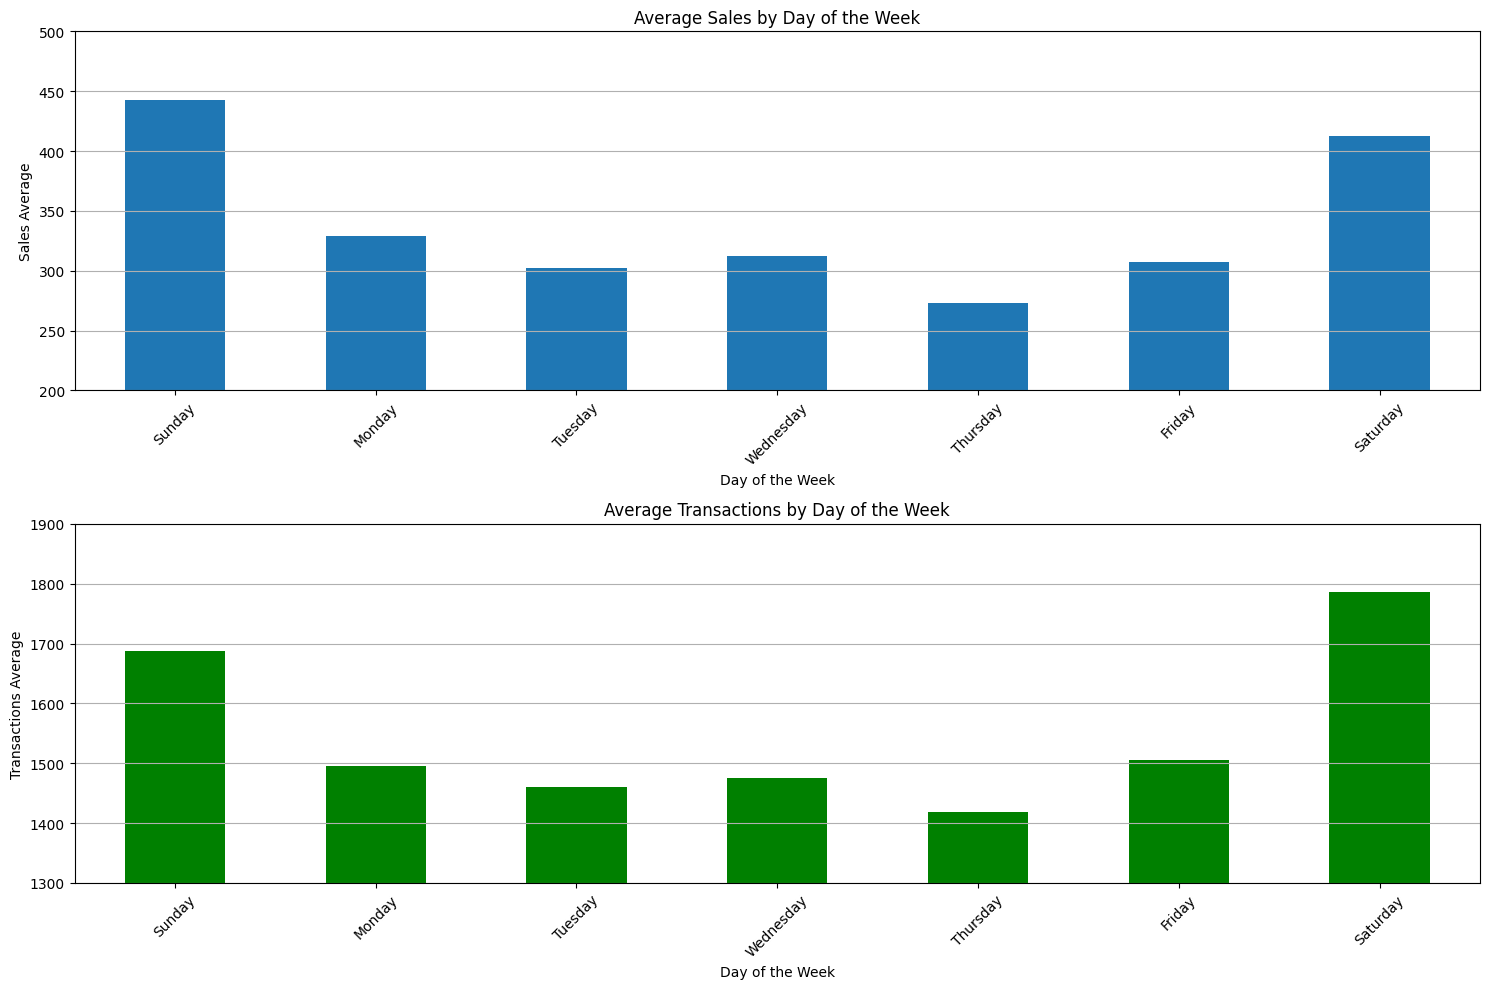

In [57]:
days_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

train_dataset.loc[:, 'day_of_week'] = train_dataset['date'].dt.day_name().copy()
avg_sales = train_dataset.groupby('day_of_week')['sales'].mean()
avg_sales = avg_sales.reindex(days_order)
avg_transactions = train_dataset.groupby('day_of_week')['transactions'].mean()
avg_transactions = avg_transactions.reindex(days_order)

fig, axes = plt.subplots(2,1, figsize=(15, 10))

avg_sales.plot(ax=axes[0], kind='bar')
axes[0].set_title('Average Sales by Day of the Week')
axes[0].set_xlabel('Day of the Week')
axes[0].set_ylabel('Sales Average')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].grid(axis='y')
axes[0].set_ylim(200, 500)

avg_transactions.plot(ax=axes[1], kind='bar', color='green')
axes[1].set_title('Average Transactions by Day of the Week')
axes[1].set_xlabel('Day of the Week')
axes[1].set_ylabel('Transactions Average')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].grid(axis='y')
axes[1].set_ylim(1300, 1900)

plt.tight_layout()
plt.show()

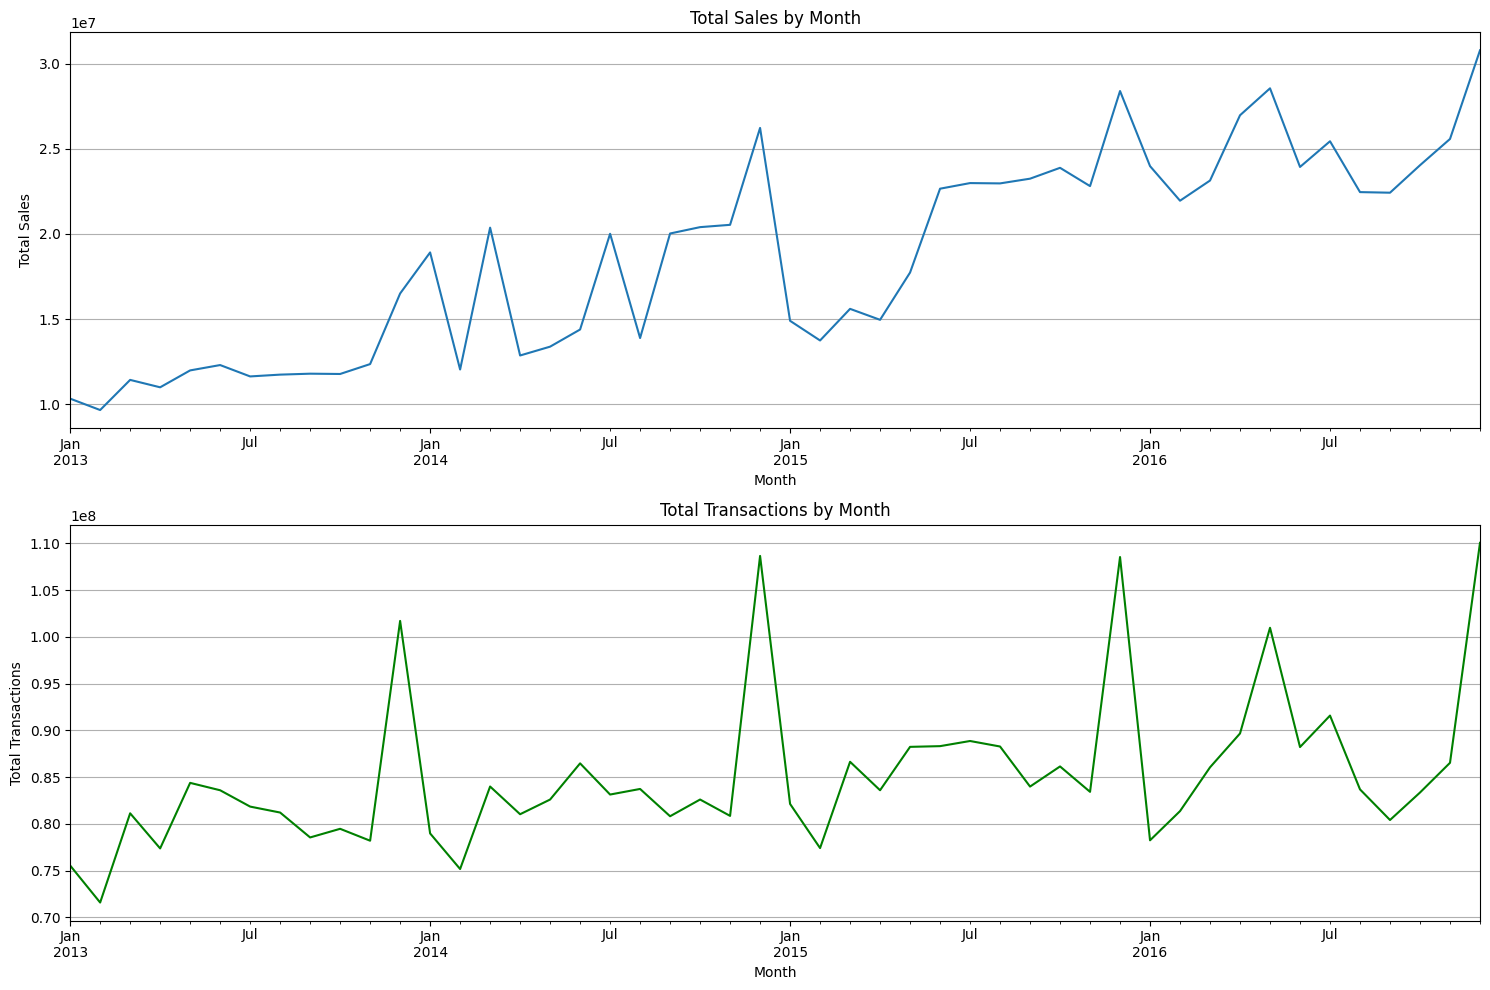

In [58]:

train_dataset.loc[:, 'month'] = train_dataset['date'].dt.to_period('M').copy()
monthly_avg_sales = train_dataset.groupby('month')['sales'].sum()
monthly_avg_transactions = train_dataset.groupby('month')['transactions'].sum()
# monthly_avg_sales = monthly_avg_sales.reindex(days_order)

fig, axes = plt.subplots(2,1, figsize=(15, 10))
monthly_avg_sales.plot(ax=axes[0], kind='line')
axes[0].set_title('Total Sales by Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Total Sales')
axes[0].grid(axis='y')

monthly_avg_transactions.plot(ax=axes[1], kind='line', color='green')
axes[1].set_title('Total Transactions by Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Total Transactions')
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

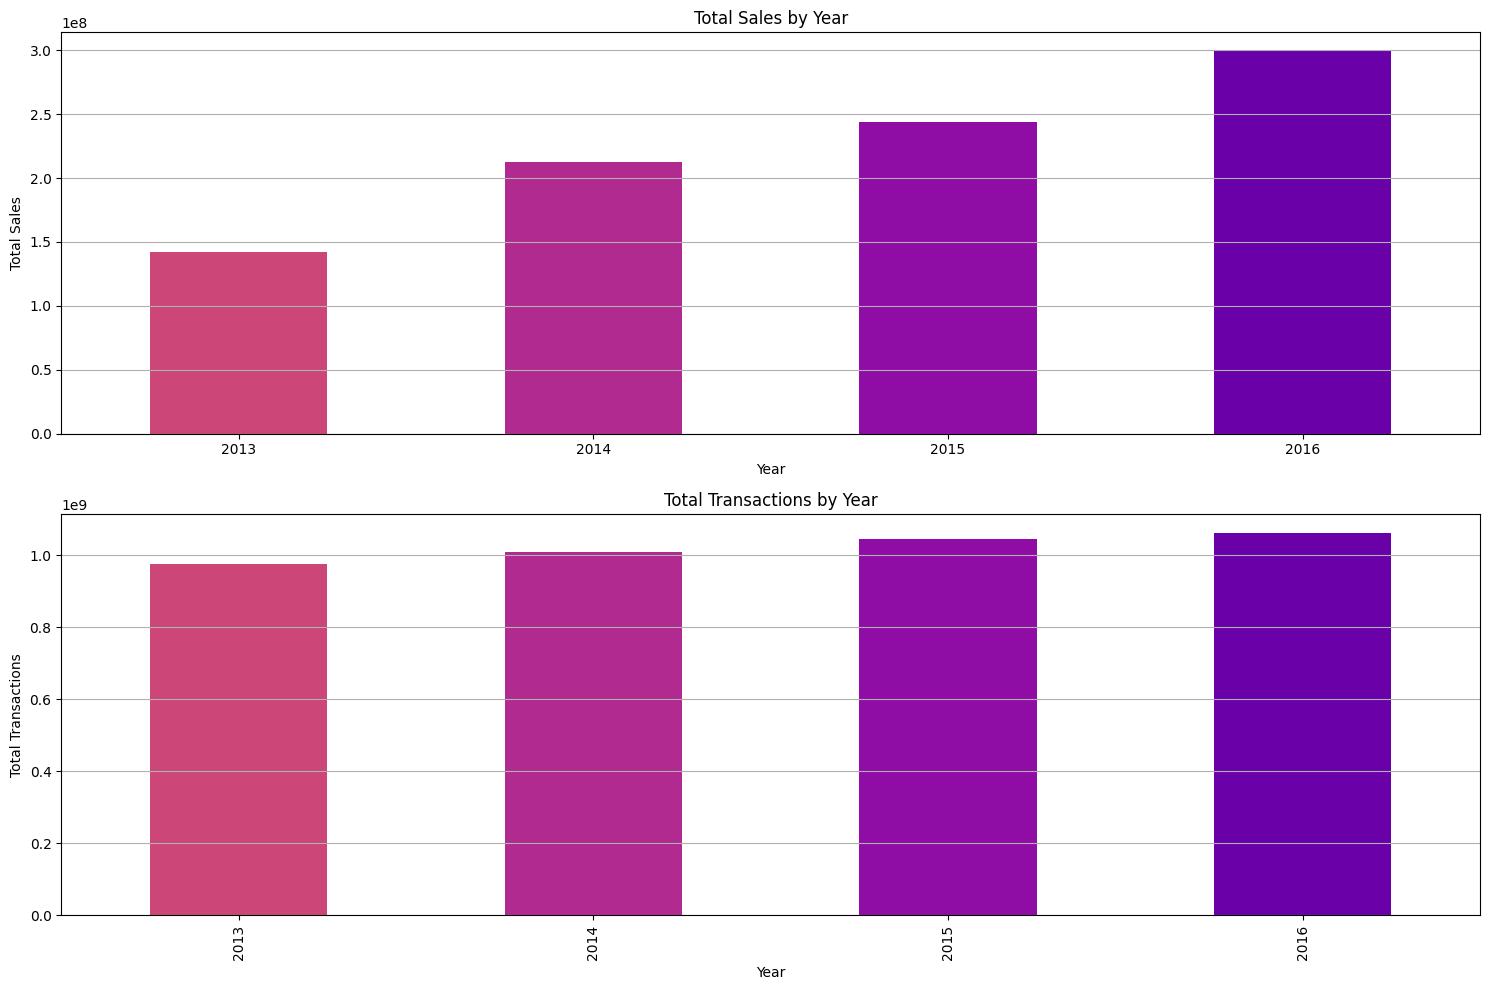

In [59]:
train_dataset['year'] = train_dataset['date'].dt.year
yearly_avg_sales = train_dataset.groupby('year')['sales'].sum()
yearly_avg_transactions = train_dataset.groupby('year')['transactions'].sum()

cmap = plt.colormaps.get_cmap('plasma')

fig, axes = plt.subplots(2,1, figsize=(15, 10))
yearly_avg_sales.plot(ax=axes[0], kind='bar', color=cmap(np.linspace(0.5, 0.2, len(yearly_avg_sales))))
axes[0].set_title('Total Sales by Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Total Sales')   
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].grid(axis='y')

yearly_avg_transactions.plot(ax=axes[1], kind='bar',  color=cmap(np.linspace(0.5, 0.2, len(yearly_avg_sales))))
axes[1].set_title('Total Transactions by Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Total Transactions')
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

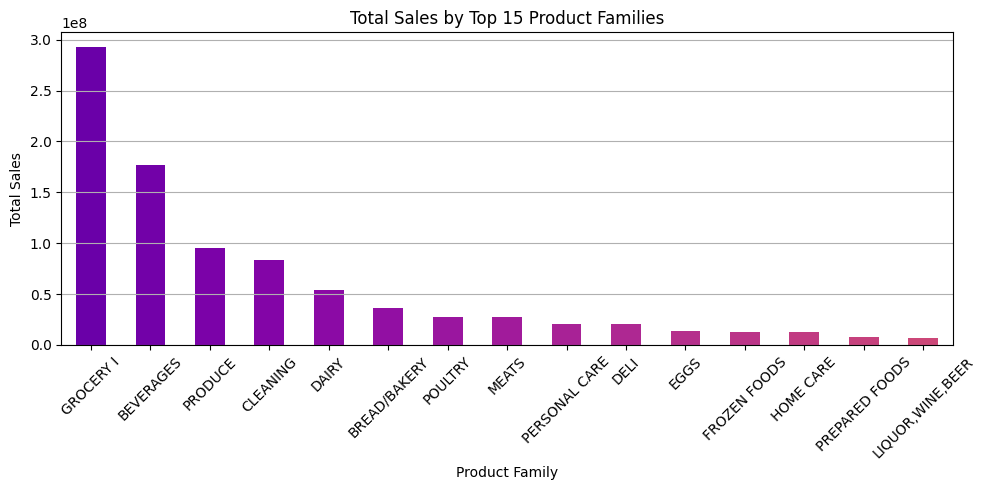

In [60]:
sales_by_product_family = train_dataset.groupby('family')['sales'].sum()
top_families = sales_by_product_family.nlargest(15)

cmap = plt.colormaps.get_cmap('plasma')

fig, ax = plt.subplots(figsize=(10, 5))
top_families.plot(ax=ax, kind='bar', color=cmap(np.linspace(0.2, 0.5, len(top_families))))

# Set titles and labels
ax.set_title('Total Sales by Top 15 Product Families')
ax.set_xlabel('Product Family')
ax.set_ylabel('Total Sales')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

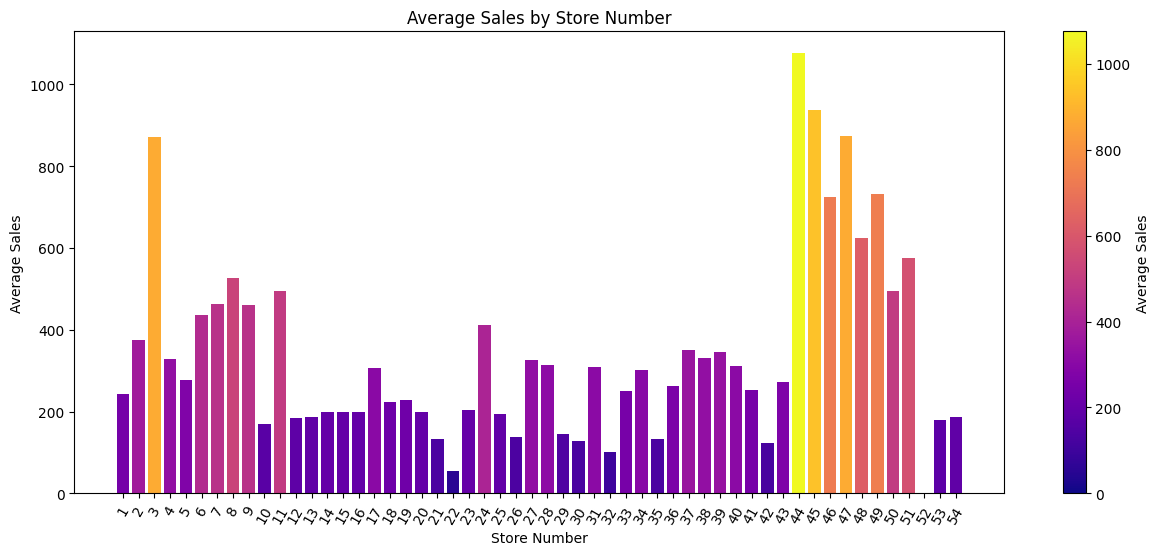

In [61]:
sales_by_store = train_dataset.groupby('store_nbr')['sales'].mean().reset_index()
sales_by_store = sales_by_store.sort_values('store_nbr')
norm = plt.Normalize(sales_by_store['sales'].min(), sales_by_store['sales'].max())

fig, ax = plt.subplots(figsize=(15, 6))
bars = ax.bar(sales_by_store['store_nbr'], sales_by_store['sales'], color=plt.cm.plasma(norm(sales_by_store['sales'])))
ax.set_xticks(sales_by_store['store_nbr'])
ax.set_xticklabels(sales_by_store['store_nbr'], rotation=60)
plt.title('Average Sales by Store Number')
plt.xlabel('Store Number')
plt.ylabel('Average Sales')

cax, _ = plt.cm.ScalarMappable(cmap="plasma", norm=norm), ax
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('Average Sales')

plt.show()

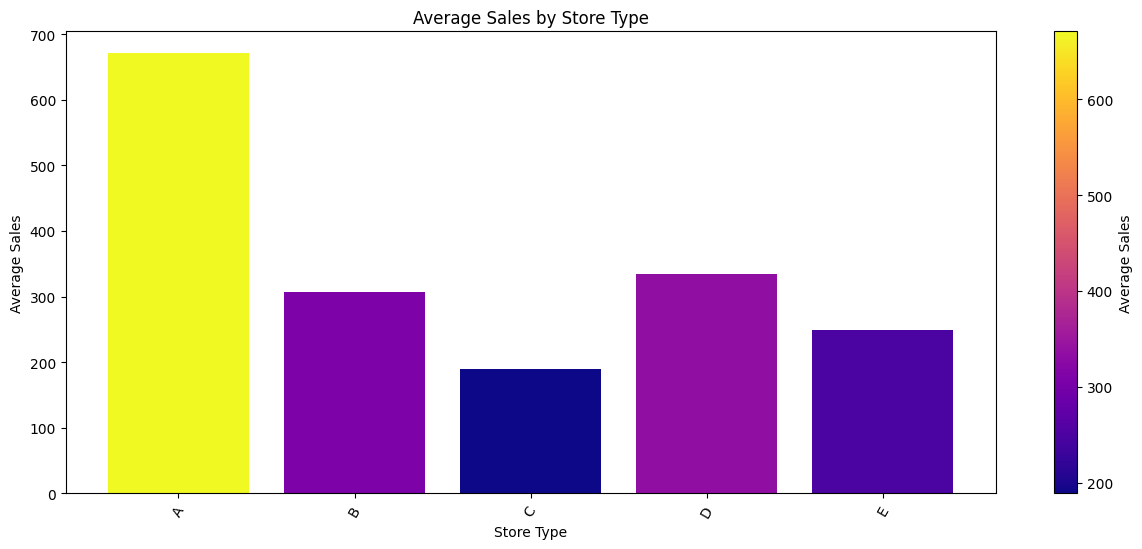

In [62]:
sales_by_store_type = train_dataset.groupby('store_type')['sales'].mean().reset_index()
sales_by_store_type = sales_by_store_type.sort_values('store_type')
norm = plt.Normalize(sales_by_store_type['sales'].min(), sales_by_store_type['sales'].max())

fig, ax = plt.subplots(figsize=(15, 6))
bars = ax.bar(sales_by_store_type['store_type'], sales_by_store_type['sales'], color=plt.cm.plasma(norm(sales_by_store_type['sales'])))
ax.set_xticks(sales_by_store_type['store_type'])
ax.set_xticklabels(sales_by_store_type['store_type'], rotation=60)
plt.title('Average Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')

cax, _ = plt.cm.ScalarMappable(cmap="plasma", norm=norm), ax
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('Average Sales')

plt.show()

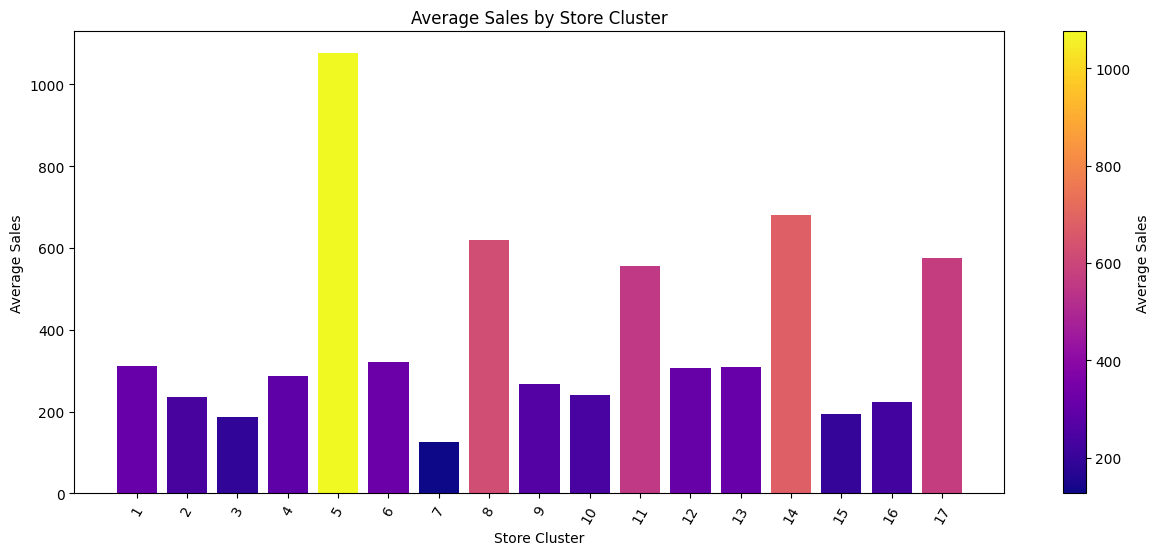

In [63]:
sales_by_cluster = train_dataset.groupby('cluster')['sales'].mean().reset_index()
sales_by_cluster = sales_by_cluster.sort_values('cluster')
norm = plt.Normalize(sales_by_cluster['sales'].min(), sales_by_cluster['sales'].max())

fig, ax = plt.subplots(figsize=(15, 6))
bars = ax.bar(sales_by_cluster['cluster'], sales_by_cluster['sales'], color=plt.cm.plasma(norm(sales_by_cluster['sales'])))
ax.set_xticks(sales_by_cluster['cluster'])
ax.set_xticklabels(sales_by_cluster['cluster'], rotation=60)
plt.title('Average Sales by Store Cluster')
plt.xlabel('Store Cluster')
plt.ylabel('Average Sales')

cax, _ = plt.cm.ScalarMappable(cmap="plasma", norm=norm), ax
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('Average Sales')

plt.show()

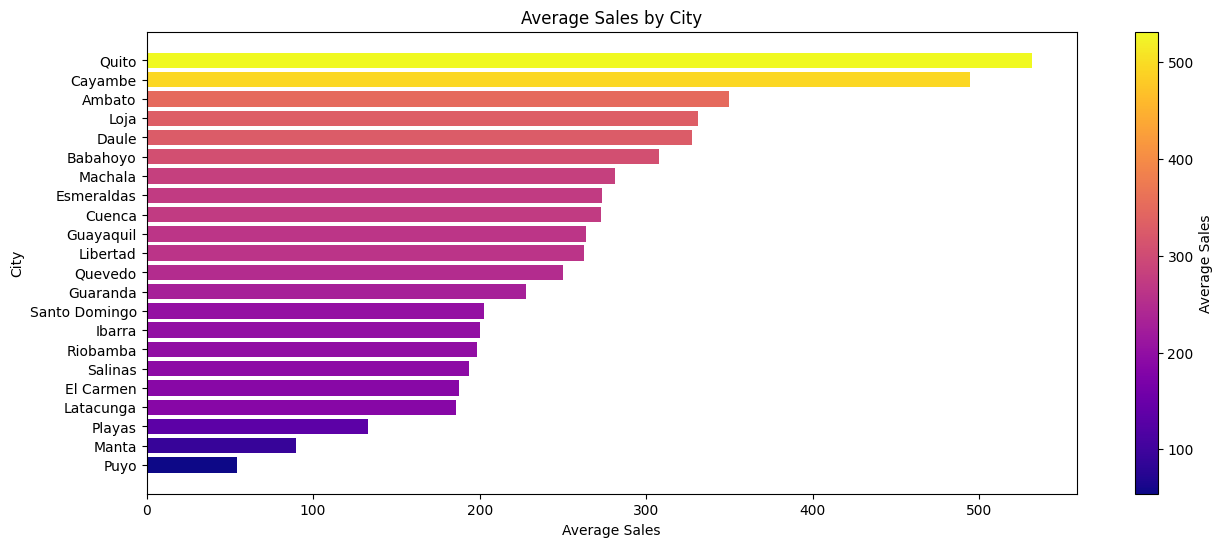

In [64]:
sales_by_city = train_dataset.groupby('city')['sales'].mean().reset_index()
sales_by_city = sales_by_city.sort_values('sales')
norm = plt.Normalize(sales_by_city['sales'].min(), sales_by_city['sales'].max())

fig, ax = plt.subplots(figsize=(15, 6))
bars = ax.barh(sales_by_city['city'], sales_by_city['sales'], color=plt.cm.plasma(norm(sales_by_city['sales'])))
# ax.set_xticks(sales_by_city['city'])
# ax.set_xticklabels(sales_by_city['city'], rotation=60)
plt.title('Average Sales by City')
plt.xlabel('Average Sales')
plt.ylabel('City')

cax, _ = plt.cm.ScalarMappable(cmap="plasma", norm=norm), ax
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('Average Sales')

plt.show()

C:\Users\Victor\AppData\Local\Temp\ipykernel_13168\3522565492.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_columns['holiday_type'] = (relevant_columns['holiday_type'] == 'Holiday').astype(int)
C:\Users\Victor\AppData\Local\Temp\ipykernel_13168\3522565492.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_columns.rename(columns={'holiday_type':'holidays'}, inplace=True)


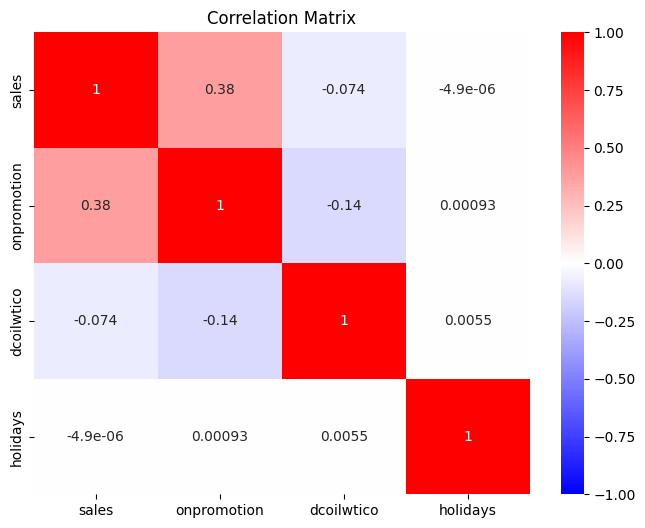

In [65]:
relevant_columns = train_dataset[['sales', 'onpromotion', 'dcoilwtico', 'holiday_type']]

# Convert holiday_type to a numeric column (binary) for correlation calculation
relevant_columns['holiday_type'] = (relevant_columns['holiday_type'] == 'Holiday').astype(int)
relevant_columns.rename(columns={'holiday_type':'holidays'}, inplace=True)

# Compute the correlation matrix
correlation_matrix = relevant_columns.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='bwr', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

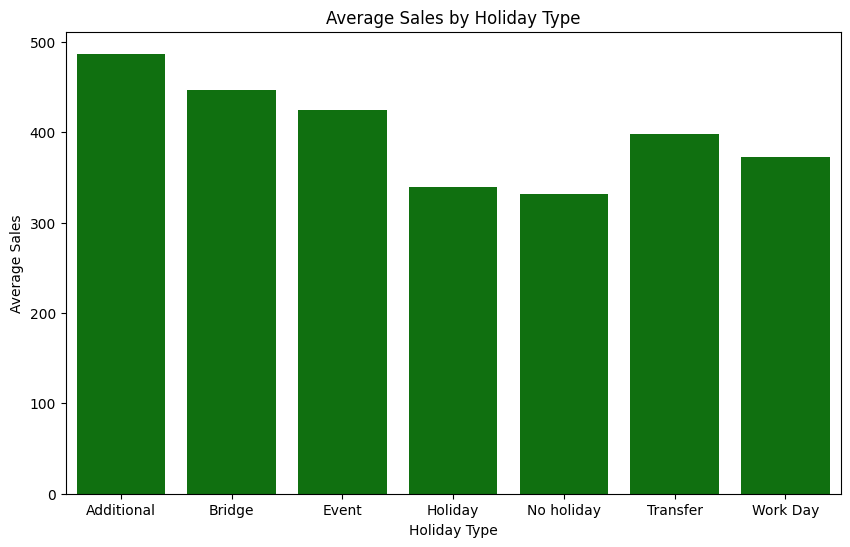

In [66]:
avg_sales = train_dataset.groupby('holiday_type')['sales'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='holiday_type', y='sales', data=avg_sales, color='green')

plt.xlabel('Holiday Type')
plt.ylabel('Average Sales')
plt.title('Average Sales by Holiday Type')
plt.show()

- Correlation Sales x Holidays not really relevant

In [67]:
def create_complementary_columns(df: pd.DataFrame):
    df.loc[:, 'day_of_week'] = df['date'].dt.day_of_week
    df.loc[:, 'month'] = df['date'].dt.month
    df.loc[:, 'year'] = df['date'].dt.year
    df.loc[:, 'day'] = df['date'].dt.day

create_complementary_columns(merged)

In [68]:
cutoff_date = pd.to_datetime('2017-01-01')
X_train = merged[merged['date'] < '2017-01-01']  
X_test = merged[merged['date'] >= '2017-01-01']

In [70]:
def drop_unnecessary_columns(df: pd.DataFrame):
    df.drop(columns=['transactions', 'holiday_type', 'locale', 'locale_name', 'description', 'transferred', 'date'], inplace=True)

drop_unnecessary_columns(X_train)
drop_unnecessary_columns(X_test)
X_train.head()

C:\Users\Victor\AppData\Local\Temp\ipykernel_13168\2104094836.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['transactions', 'holiday_type', 'locale', 'locale_name', 'description', 'transferred', 'date'], inplace=True)
C:\Users\Victor\AppData\Local\Temp\ipykernel_13168\2104094836.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['transactions', 'holiday_type', 'locale', 'locale_name', 'description', 'transferred', 'date'], inplace=True)


,id,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,day_of_week,month,year,day
0,0,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,1,1,2013,1
1,1,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,1,1,2013,1
2,2,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,1,1,2013,1
3,3,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,1,1,2013,1
4,4,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,1,1,2013,1


In [71]:
scaler = StandardScaler()
numerical_cols = ['sales', 'dcoilwtico']
scaler.fit(X_train[numerical_cols])

X_train_scaled = X_train.copy()
X_train_scaled[numerical_cols] = scaler.transform(X_train[numerical_cols])

X_test_scaled = X_test.copy()
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

X_train_scaled.head()

,id,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,day_of_week,month,year,day
0,0,1,AUTOMOTIVE,-0.320272,0,Quito,Pichincha,D,13,0.849157,1,1,2013,1
1,1,1,BABY CARE,-0.320272,0,Quito,Pichincha,D,13,0.849157,1,1,2013,1
2,2,1,BEAUTY,-0.320272,0,Quito,Pichincha,D,13,0.849157,1,1,2013,1
3,3,1,BEVERAGES,-0.320272,0,Quito,Pichincha,D,13,0.849157,1,1,2013,1
4,4,1,BOOKS,-0.320272,0,Quito,Pichincha,D,13,0.849157,1,1,2013,1


In [72]:
encoder = OneHotEncoder(sparse_output=False)
categorical_cols = ['city', 'state', 'family', 'store_type']

encoded_train_data = encoder.fit_transform(X_train_scaled[categorical_cols])
encoded_train_df = pd.DataFrame(encoded_train_data, columns=encoder.get_feature_names_out(categorical_cols), index=X_train_scaled.index)
X_train_encoded = pd.concat([X_train_scaled, encoded_train_df], axis=1)
X_train_encoded.drop(categorical_cols, axis=1, inplace=True)

encoded_test_data = encoder.transform(X_test_scaled[categorical_cols])
encoded_test_df = pd.DataFrame(encoded_test_data, columns=encoder.get_feature_names_out(categorical_cols), index=X_test_scaled.index)
X_test_encoded = pd.concat([X_test_scaled, encoded_test_df], axis=1)
X_test_encoded.drop(categorical_cols, axis=1, inplace=True)


In [73]:
X_train_encoded.head()

,id,store_nbr,sales,onpromotion,cluster,dcoilwtico,day_of_week,month,year,day,...,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,store_type_A,store_type_B,store_type_C,store_type_D,store_type_E
0,0,1,-0.320272,0,13,0.849157,1,1,2013,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,1,-0.320272,0,13,0.849157,1,1,2013,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,1,-0.320272,0,13,0.849157,1,1,2013,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,1,-0.320272,0,13,0.849157,1,1,2013,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4,1,-0.320272,0,13,0.849157,1,1,2013,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
X_test_encoded.head()

,id,store_nbr,sales,onpromotion,cluster,dcoilwtico,day_of_week,month,year,day,...,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,store_type_A,store_type_B,store_type_C,store_type_D,store_type_E
2642706,2596374,1,-0.320272,0,13,-0.691311,6,1,2017,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2642707,2596375,1,-0.320272,0,13,-0.691311,6,1,2017,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2642708,2596376,1,-0.320272,0,13,-0.691311,6,1,2017,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2642709,2596377,1,-0.320272,0,13,-0.691311,6,1,2017,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2642710,2596378,1,-0.320272,0,13,-0.691311,6,1,2017,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [47]:
# store_to_predict = 10

# y_train = X_train_encoded['sales']
# X_train = X_train_encoded.drop('sales', axis=1)

# y_train = y_train[X_train['store_nbr'] == store_to_predict]
# X_train = X_train[X_train['store_nbr'] == store_to_predict].drop(columns='store_nbr')


# y_test = X_test_encoded['sales']
# X_test = X_test_encoded.drop('sales', axis=1)

# y_test = y_test[X_test['store_nbr'] == store_to_predict]
# X_test = X_test[X_test['store_nbr'] == store_to_predict].drop(columns='store_nbr')


# X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2642706, 85), (2642706,), (411642, 85), (411642,))

In [ ]:
# rf_model = RandomForestRegressor(random_state=42)
# rf_model.fit(X_train, y_train)
# rf_predictions = rf_model.predict(X_test)

# y_eval_abs = abs(y_test)
# rf_predictions_abs = abs(rf_predictions)
# rf_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, rf_predictions_abs))

# results_rf = pd.DataFrame({'Model': ['Random Forest'],
#                             'RMSLE': [rf_rmsle]})

# results_rf

In [75]:
def train_all_stores(stores, X_train:pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame):
    y_eval_list = []
    model_predict_list = []
    models = {}

    for store_to_predict in stores:
        if store_to_predict == 11:
            break
        print(f'Store: {store_to_predict}')
        y_train_store = y_train[X_train['store_nbr'] == store_to_predict]
        X_train_store = X_train[X_train['store_nbr'] == store_to_predict].drop(columns='store_nbr')
        
        y_test_store = y_test[X_test['store_nbr'] == store_to_predict]
        X_test_Store = X_test[X_test['store_nbr'] == store_to_predict].drop(columns='store_nbr')
        
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train_store, y_train_store) 
        y_pred = model.predict(X_test_Store)

        y_eval_list.extend(y_test_store)
        model_predict_list.extend(y_pred)
        
        
        models[store_to_predict] = model
    
    rmsle_score = np.sqrt(mean_squared_log_error(np.abs(y_eval_list), np.abs(model_predict_list)))

    return {
        'RMSLE': rmsle_score,
        'models': models
    }

rf_models = train_all_stores(list(X_train_encoded['store_nbr'].unique()), 
                             X_train=X_train_encoded.drop('sales', axis=1), y_train= X_train_encoded['sales'],
                             X_test=X_train_encoded.drop('sales', axis=1), y_test= X_train_encoded['sales']
                             )
rf_models

Store: 1
Store: 10


{'RMSLE': 0.015534511818983358,
 'models': {1: RandomForestRegressor(random_state=42),
  10: RandomForestRegressor(random_state=42)}}